In [354]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
from qiskit import QuantumCircuit
import numpy as np
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import DensityMatrix, concurrence, Statevector

plt.rcParams["figure.figsize"] = [8, 28]
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'font.size': 10})

# QHack Visualization Challenge

In this code we present a way to visualize the quantum states given a quantum circuit using tubes.

## First we are gona built all the required function and explain each of them.

In [244]:
# This function creates a cylinder in our plot.

def data_for_cylinder_along_z(center_x,center_y,radius,height_z, th):
    """A function that plot a cylinder in the plot.

    Args:
        center_x (float): center in x direction.
        center_y (float): center in y direction.
        radious (float): radious for the cylinder.
        height_z (float): height for the z direction.
        h (float): threshold for the cylinder in the z direction.

    Returns:
        x_grid : x grid for the plot (matplotlib).
        y_grid : y grid for the plot (matplotlib).
        z_grid : z grid for the plot (matplotlib).
    """
    
    z = np.linspace(th, height_z, 200)
    theta = np.linspace(0, 2*np.pi, 200)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

### The general Qubit representation.

$$ |\psi \rangle = cos(\frac{\theta}{2})|0\rangle + e^{i\phi}sin(\frac{\theta}{2})|1\rangle $$

**Missing the matrix representation.**

In [ ]:
def calculation(matrix):
    """A function that takes a 2x2 matrix and give the
    zero, one probabilities and phi angle give for the
    equation [1]

    Args:
        matrix (np.array) : matrix of the system
    
    Returns:
        zero (float) : zero probability
        one (float) : one probability
        phi (float) : relative phase.
    """

    zero = matrix[0][0]
    one = matrix[1][1]

    if (matrix[0][1]== 0 or matrix[1][0]== 0): #### IS MISSING
        phi = 0
    else:
        
        phi = np.log(matrix[0][1]/matrix[1][0])/(-2j)
        #print(np.log(matrix[1][0]/matrix[0][1])/(-2j))

    return zero, one, phi

As an example of the previuos code we have:

In [356]:
# Example usign the previous function.

theta = np.pi/2
phi = np.pi/2

zero = np.cos(theta/2)
one = np.exp(1j*phi)*np.sin(theta/2)

rho_H_matrix = np.array([[zero*zero, zero*np.conj(one)],[ one*zero, one*np.conj(one)]])

calculation(rho_H_matrix)

((0.5000000000000001+0j),
 (0.5000000000000001+0j),
 (1.5707963267948966+3.749399456654644e-33j))

In [245]:
def qubit(ax, number, zero_amp, one_amp, phase, ent):
    """A function that creates the state of the qubit on the plot.

    Args:
        ax (matplolib.ax) : axis for the plot
        number (int) : number of the qubit.
        zero_amp (float) : zero probability.
        one_amp (float) : one probability.
        phase (float) : phase of the qubit.
        ent (int) : define is the qubit is entanglement with somethig more.

    Returns:
        Just plot the qubit on the ax.
    """

    if ent == 0:

        x, y, z = data_for_cylinder_along_z(5*number, 0, 1, 2, 0)

        x_z, y_z, z_z = data_for_cylinder_along_z(5*number, 0, 1, 1+zero_amp, 1)
        x_o, y_o, z_o = data_for_cylinder_along_z(5*number, 0, 1, 1-one_amp, 1)

        ph = np.abs(phase/(2*np.pi))

        p = Circle((5*number, 0), 2, alpha=0.5, color = (0, ph, ph)) # phase

        p_z = Circle((5*number, 0), 1, alpha=1, color = ('y'))
        p_o = Circle((5*number, 0), 1, alpha=1, color = 'r')

        ax.plot_surface(x, y, z, alpha=0.05, color = 'b')
        ax.plot_surface(x_z, y_z, z_z, alpha=1, color='y') 
        ax.plot_surface(x_o, y_o, z_o, alpha=1, color='r') 

        ax.add_patch(p)
        ax.add_patch(p_z)
        ax.add_patch(p_o)
        
        art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
        art3d.pathpatch_2d_to_3d(p_z, z=1+zero_amp, zdir="z")
        art3d.pathpatch_2d_to_3d(p_o, z=1-one_amp, zdir="z")
    
    else:

        x, y, z = data_for_cylinder_along_z(5*number, 0, 1, 2, 0)

        ax.plot_surface(x, y, z, alpha=1, color = 'm')

        p = Circle((5*number, 0), 2, alpha=0.5, color = 'm') # phase

        ax.add_patch(p)

        art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")

In [345]:
def is_entanglement(qubit, qubits, matrix):
    """A function that check if a qubit is entangled with other one.

    Args:
        qubit (int) : the qubit to check.
        qubits (int) : the number of qubits.
        matrix (np.array) : the matrix of the system.

    Returns:
        ent (bool) : if the qubit is entangled.

    """
    ent = False

    qubit_list = []

    for i in range(qubits):
        qubit_list.append(i)

    qubit_list.remove(qubit)

    for i in qubit_list:
        new_list = qubit_list.copy()
        new_list.remove(i)

        trace_matrix = qi.partial_trace(matrix, new_list)

        concu = concurrence(trace_matrix)

        if concu > 0.99:
            ent = True

    return ent

In [361]:
def plot_circuit_tubes(qubits, density_matrix):
    """A function that plot the circuit with tubes.

    Args:
        qubits (int) : the number of qubits.
        density_matrix (np.array) : the density matrix of the system.

    Returns:
        The plot using matplotlib.
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(qubits):

        qubit_list = []

        for j in range(qubits):
            if j!=i:
                qubit_list.append(j)

        if is_entanglement(i,qubits,density_matrix) == True:

            qubit(ax, i, 0, 0, 0, 1)

        else:

            qubit_matrix = np.array(qi.partial_trace(density_matrix, qubit_list))
            m = np.array(qubit_matrix)
            zero, one, phi = calculation(m)
            qubit(ax, i, zero, one, phi, 0)

    plt.xlim(-1,qubits*4)
    plt.ylim(-4,4)
    
    ax.set_zlim(0,2)

    ax.grid(False)
    ax.axis('off')

    ax.view_init(15, 85)

    return plt.show()

c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1813: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


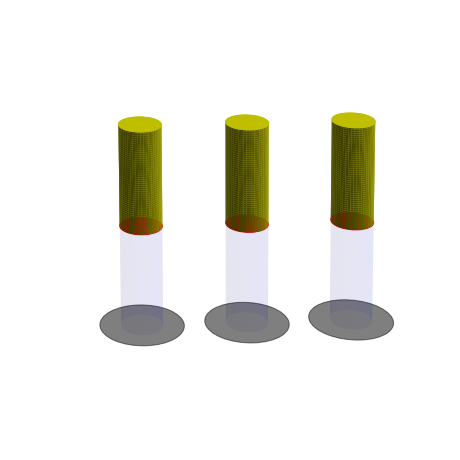

In [362]:
# Just a easy state.

qc = QuantumCircuit(3)

rho_CD = qi.DensityMatrix.from_instruction(qc)
rho_CD = np.array(rho_CD)

plot_circuit_tubes(3, rho_CD)

c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1813: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


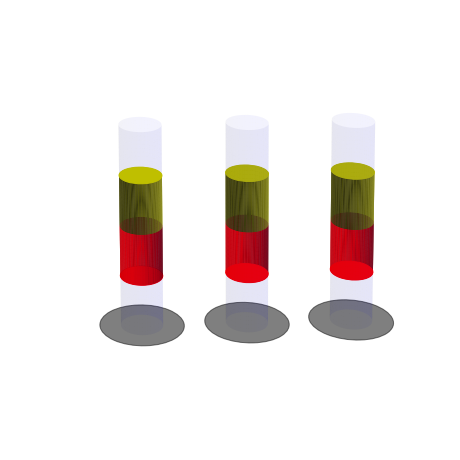

In [363]:
# All using the Hadamard.

qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)
qc.h(2)

rho_CD = qi.DensityMatrix.from_instruction(qc)
rho_CD = np.array(rho_CD)

plot_circuit_tubes(3, rho_CD)

c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1813: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
c:\Users\Kevin Joven\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


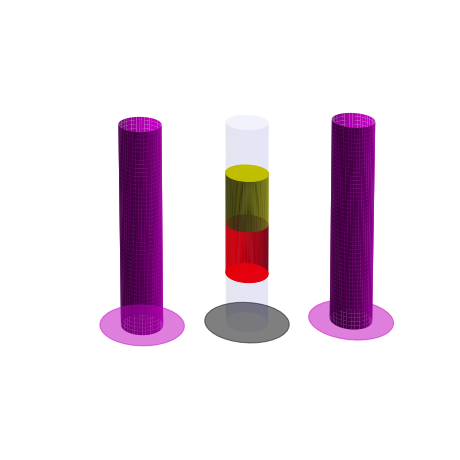

In [364]:
# Lets entangled this qubits.

qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)
qc.cnot(0,2)

rho_CD = qi.DensityMatrix.from_instruction(qc)
rho_CD = np.array(rho_CD)

plot_circuit_tubes(3, rho_CD)

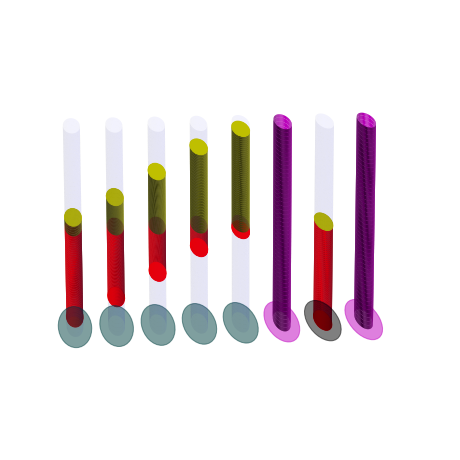

In [365]:
# Lets do it bigger.

qc = QuantumCircuit(8)
qc.h(0)
qc.x(1)
qc.i(2)
qc.cnot(0,2)
qc.rx(0.5,3)
qc.rx(1,4)
qc.rx(1.5,5)
qc.rx(2,6)
qc.rx(2.5,7)

rho_CD = qi.DensityMatrix.from_instruction(qc)
rho_CD = np.array(rho_CD)

plot_circuit_tubes(8, rho_CD)

# Some tests:

In [357]:
s = np.array([[0.5,0,0,0.5],[0,0,0,0],[0,0,0,0],[0.5,0,0,0.5]])
m = np.array([[0.5,0,0,0,0,0,0,0.5],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0],
              [0.5,0,0,0,0,0,0,0.5]])

is_entanglement(0,3,m)

False

In [360]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cnot(0,1)
qc.cnot(1,2)

Den = DensityMatrix(qc)
a = qi.partial_trace(Den, [2])
a

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))
